<a href="https://colab.research.google.com/github/ktsim01/Speech-Emotion-Recognition/blob/main/Speech_Emotion_Regocnition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Sources

**The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)** https://zenodo.org/record/1188976#.YvK5gS1h2P0

**Toronto Emotional Speech Set (TESS)** https://tspace.library.utoronto.ca/handle/1807/24487


Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Import the necessary libraries

In [3]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install json-tricks


In [4]:
%%capture
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

First, we create methods that sync the different file name formats of RAVDESS and TESS.

In [5]:
def emotion_TESS(name):
  if('neutral' in name): return "01"
  elif('happy' in name): return "03"
  elif('sad' in name): return "04"
  elif('angry' in name): return "05"
  elif('fear' in name): return "06"
  elif('disgust' in name): return "07"
  elif('ps' in name): return "08"
  else: return "-1"

# Returns an enum for corresponding emotion
def emotionfix(e_num):
  if e_num == "01":   return 0 # neutral
  elif e_num == "02": return 1 # calm
  elif e_num == "03": return 2 # happy
  elif e_num == "04": return 3 # sad
  elif e_num == "05": return 4 # angry
  elif e_num == "06": return 5 # fear
  elif e_num == "07": return 6 # disgust
  else:               return 7 # suprised

In [6]:
# Getting the maximum length of sample
path = './drive/MyDrive/Audio Files'
max_length = -1.0
for subdir, dirs, files in os.walk(path):
  for file in files: 
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)
     
    max_length=max(max_length, len(xt))

print('Maximum length:', max_length)                   

Maximum length: 204288


# Preprocessing and feature extraction
Now we will go preprocess the audio files to better prepare them for training. Specifically, we will 
load the audio into an AudioSegment object. This object is then going to be normalized to +5.0dBFS. After changing this object to an array, we will cut ouf the silence in the beginning and the end. Finally, we will equalize the audio length and perform noise reduction

In [16]:
import time
tic = time.perf_counter()

rms = [] # Root Mean Square
zcr = [] # Zero Crossed Rate
mfcc = [] # Mel-Frequency Cepstral Coefficients
emotions = []

total_length = 228864 # desired frame length for all files
# Every 2048 samples are analyzed and translated into 4 feature values
frame_length = 2048
hop_length = 512

folder_path = '/content/drive/My Drive/Audio Files' 

for subdir, dirs, files in os.walk(folder_path):
  for file in files: 

      _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs.
    # Load the audio file.
      rawsound = AudioSegment.from_file(os.path.join(subdir,file)) 
    # Normalize the audio to +5.0 dBFS.
      normalizedsound = effects.normalize(rawsound, headroom = 0) 
    # Transform the normalized audio to np.array of samples.
      normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
      xt, index = librosa.effects.trim(normal_x, top_db=30)
      print(file,"\t", len(xt), "\t", rawsound.dBFS, "\t", normalizedsound.dBFS) #--QA purposes if needed-- 
    # Pad for duration equalization.
      padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant')
    # Noise reduction.
      final_x = nr.reduce_noise(padded_x, sr=sr) #updated 03/03/22
       
   # Features extraction 
      f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square   
      f2 = librosa.feature.zero_crossing_rate(final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR      
      f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
      
   # Emotion extraction from the different databases
      if (emotion_TESS(file) != "-1"): #TESS database validation
            name = emotion_TESS(file)
      else:                              #RAVDESS database validation
            name = file[6:8]                      

   # Filling the data lists  
      rms.append(f1)
      zcr.append(f2)
      mfcc.append(f3)
      emotions.append(emotionfix(name)) 

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

03-01-01-01-02-01-01.wav 	 61440 	 -45.90683693839325 	 -21.218198999897982
03-01-02-01-01-01-01.wav 	 75264 	 -50.663574038402984 	 -18.966117795281214
03-01-01-01-01-02-01.wav 	 62976 	 -47.3864379856296 	 -21.01920775051493
03-01-01-01-01-01-01.wav 	 68608 	 -47.96357278607907 	 -20.127637798851126
03-01-01-01-02-02-01.wav 	 58368 	 -46.22659904607586 	 -22.164580840646426
03-01-02-01-02-01-01.wav 	 76800 	 -47.3864379856296 	 -19.103690741940063
03-01-02-02-01-01-01.wav 	 86016 	 -52.35645687338553 	 -19.482407145860485
03-01-02-01-01-02-01.wav 	 160768 	 -50.22257122354151 	 -20.414778195089106
03-01-02-01-02-02-01.wav 	 73728 	 -46.96265200423083 	 -20.411998265592473
03-01-02-02-02-01-01.wav 	 118272 	 -50.22257122354151 	 -17.238959759935703
03-01-02-02-02-02-01.wav 	 111104 	 -49.40253912346121 	 -18.82374210505382
03-01-03-01-01-01-01.wav 	 73728 	 -42.88764145375963 	 -18.23096206456093
03-01-02-02-01-02-01.wav 	 102400 	 -51.619029674323 	 -20.233185038050735
03-01-03-01-01

In order to fit the data extracted above into a model, we need to make final adjustments. Specifically, we need a shape in a 3d format: (batch, timesteps, feature). Then we will concatenate all the features will into an X variable while the Y variable will represent emotions in 2d.

In [17]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)

f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (4240, 448, 1)
RMS shape: (4240, 448, 1)
MFCCs shape: (4240, 448, 13)


In [18]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

In [ ]:
# Save X,Y arrays as lists to json files.

x_data = X.tolist() 
x_path = '/content/drive/My Drive/Colab Notebooks/X_datanew.json' # FILE SAVE PATH
dump(obj = x_data, fp = x_path)

y_data = Y.tolist() 
y_path = '/content/drive/My Drive/Colab Notebooks/Y_datanew.json' # FILE SAVE PATH
dump(obj = y_data, fp = y_path)

Now, we will split X,Y into training, validation, and test sets. In addition, y_train and y_val will be converted to one-vector: this is so that we can deal with numerical data instead of categorial data for training

In [22]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 8, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 8, dtype = 'int8')

In [23]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(3710, 448, 15)
(368, 448, 15)
(162, 448, 15)


In [36]:
# Save x_test, y_test to JSON.

dump(obj = x_test, fp ='x_test_data.json')
dump(obj = y_test, fp ='y_test_data.json')

'{"__ndarray__": [[2], [5], [3], [0], [1], [5], [3], [2], [2], [4], [3], [5], [0], [5], [5], [7], [6], [6], [7], [6], [4], [7], [0], [4], [2], [2], [0], [6], [6], [2], [6], [2], [3], [0], [2], [0], [2], [7], [4], [7], [4], [2], [6], [3], [1], [6], [3], [7], [4], [5], [3], [7], [3], [7], [3], [6], [5], [5], [6], [3], [3], [0], [7], [7], [0], [7], [7], [5], [6], [5], [4], [6], [3], [4], [6], [1], [0], [7], [6], [0], [2], [2], [4], [6], [3], [5], [0], [5], [0], [5], [7], [3], [7], [2], [7], [3], [2], [0], [2], [3], [6], [0], [7], [6], [2], [2], [6], [3], [4], [5], [7], [3], [7], [3], [6], [0], [5], [3], [6], [4], [6], [0], [7], [6], [4], [7], [6], [0], [2], [3], [5], [6], [2], [0], [4], [2], [5], [0], [3], [5], [1], [3], [3], [7], [2], [3], [7], [5], [6], [2], [6], [5], [7], [7], [0], [3], [6], [3], [2], [0], [4], [3]], "dtype": "int8", "shape": [162, 1], "Corder": true}'

Using keras library, we will train the model with 2 hidden LSTM layers (good for processing sequence of data and long term dependencies). The output layer has 8 nodes where softmax activation is used (vector of numbers translated to vector of probabilities). RMSprop was used so as to increase the learning rate by restricting vertical oscillation: this can allow the algorithm to take larger steps towards convergence.

In [14]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 

In [28]:
# Initializing the model

model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(8, activation = 'softmax'))
print(model.summary())

batch_size = 30

# Callbacks functions
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)
                             
# Compile & train   
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class, 
                      epochs=340, batch_size = batch_size, 
                      validation_data = (x_val, y_val_class), 
                      callbacks = [mcp_save, rlrop])
# Define the best weights to the model.
model.load_weights(checkpoint_path)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 448, 64)           20480     
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
Total params: 54,024
Trainable params: 54,024
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/340
124/124 [==============================] - 44s 329ms/step - loss: 2.0304 - categorical_accuracy: 0.1668 - val_loss: 1.9473 - val_categorical_accuracy: 0.2364 - lr: 0.0010
Epoch 2/340
124/124 [==============================] - 40s 322ms/step - loss: 1.8786 - categorical_accuracy: 0.2609 - val_loss

KeyboardInterrupt: ignored

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

In [30]:
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

12/12 - 1s - loss: 0.8540 - categorical_accuracy: 0.7147 - 1s/epoch - 112ms/step


In [32]:
# Saving model & weights

from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723_weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)
    
model.save_weights(saved_weights_path)
print("Saved model to disk")

Saved model to disk


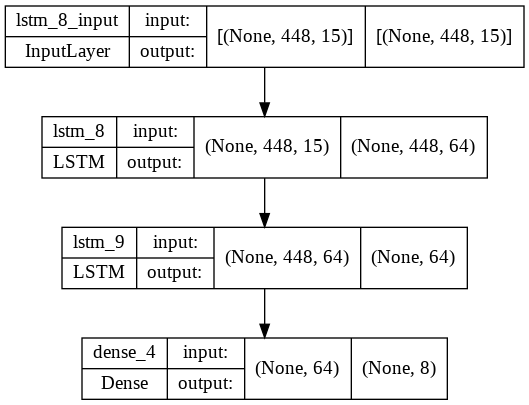

In [33]:
# Reading the model from JSON file

saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723_weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()
    
# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [37]:
x_test = load('x_test_data.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load('y_test_data.json')
y_test = np.asarray(y_test).astype('int8')

y_test_class = tf.keras.utils.to_categorical(y_test, 8, dtype = 'int8')

In [38]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

6/6 - 2s - loss: 0.9932 - categorical_accuracy: 0.6543 - 2s/epoch - 339ms/step


Now we are going to use the model we created to implement the real-time SER.

In [39]:
saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723_weights.h5'

#Reading the model from JSON file
with open(saved_model_path, 'r') as json_file:
    json_savedModel = json_file.read()
    
# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 448, 64)           20480     
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
Total params: 54,024
Trainable params: 54,024
Non-trainable params: 0
_________________________________________________________________
None


We will once again use the similar preprocessing method we used previously.

In [40]:
def preprocess(file_path, frame_length = 2048, hop_length = 512):
    '''
    A process to an audio .wav file before execcuting a prediction.
      Arguments:
      - file_path - The system path to the audio file.
      - frame_length - Length of the frame over which to compute the speech features. default: 2048
      - hop_length - Number of samples to advance for each frame. default: 512

      Return:
        'X_3D' variable, containing a shape of: (batch, timesteps, feature) for a single file (batch = 1).
    ''' 
    # Fetch sample rate.
    _, sr = librosa.load(path = file_path, sr = None)
    # Load audio file
    rawsound = AudioSegment.from_file(file_path, duration = None) 
    # Normalize to 5 dBFS 
    normalizedsound = effects.normalize(rawsound, headroom = 5.0) 
    # Transform the audio file to np.array of samples
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32') 
    # Noise reduction                  
    final_x = nr.reduce_noise(normal_x, sr=sr, use_tensorflow=True)
        
        
    f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length, center=True, pad_mode='reflect').T # Energy - Root Mean Square
    f2 = librosa.feature.zero_crossing_rate(final_x, frame_length=frame_length, hop_length=hop_length,center=True).T # ZCR
    f3 = librosa.feature.mfcc(final_x, sr=sr, S=None, n_mfcc=13, hop_length = hop_length).T # MFCC   
    X = np.concatenate((f1, f2, f3), axis = 1)
    
    X_3D = np.expand_dims(X, axis=0)
    
    return X_3D

In [41]:
emotions = {
    0 : 'neutral',
    1 : 'calm',
    2 : 'happy',
    3 : 'sad',
    4 : 'angry',
    5 : 'fearful',
    6 : 'disgust',
    7 : 'suprised'   
}

emo_list = list(emotions.values())

def is_silent(data):
    # Returns 'True' if below the 'silent' threshold
    return max(data) < 100

In [48]:
%%capture
!pip install pyaudio

In [47]:
import pyaudio
import wave
from array import array
import struct
import time

# Initialize variables
RATE = 24414
CHUNK = 512
RECORD_SECONDS = 7.1

FORMAT = pyaudio.paInt32
CHANNELS = 1
WAVE_OUTPUT_FILE = "/content/drive/My Drive/Colab Notebooks/output.wav"

# Open an input channel
p = pyaudio.PyAudio()
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)


# Initialize a non-silent signals array to state "True" in the first 'while' iteration.
data = array('h', np.random.randint(size = 512, low = 0, high = 500))

# SESSION START
print("** session started")
total_predictions = [] # A list for all predictions in the session.
tic = time.perf_counter()

while is_silent(data) == False:
    print("* recording...")
    frames = [] 
    data = np.nan # Reset 'data' variable.

    timesteps = int(RATE / CHUNK * RECORD_SECONDS) # => 339

    # Insert frames to 'output.wav'.
    for i in range(0, timesteps):
        data = array('l', stream.read(CHUNK)) 
        frames.append(data)

        wf = wave.open(WAVE_OUTPUT_FILE, 'wb')
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(p.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(frames))

    print("* done recording")

    x = preprocess(WAVE_OUTPUT_FILE) # 'output.wav' file preprocessing.
    # Model's prediction => an 8 emotion probabilities array.
    predictions = model.predict(x, use_multiprocessing=True)
    pred_list = list(predictions)
    pred_np = np.squeeze(np.array(pred_list).tolist(), axis=0) # Get rid of 'array' & 'dtype' statments.
    total_predictions.append(pred_np)
    
    # Present emotion distribution for a sequence (7.1 secs).
    fig = plt.figure(figsize = (10, 2))
    plt.bar(emo_list, pred_np, color = 'darkturquoise')
    plt.ylabel("Probabilty (%)")
    plt.show()
    
    max_emo = np.argmax(predictions)
    print('max emotion:', emotions.get(max_emo,-1))
    
    print(100*'-')
    
    # Define the last 2 seconds sequence.
    last_frames = np.array(struct.unpack(str(96 * CHUNK) + 'B' , np.stack(( frames[-1], frames[-2], frames[-3], frames[-4],
                                                                            frames[-5], frames[-6], frames[-7], frames[-8],
                                                                            frames[-9], frames[-10], frames[-11], frames[-12],
                                                                            frames[-13], frames[-14], frames[-15], frames[-16],
                                                                            frames[-17], frames[-18], frames[-19], frames[-20],
                                                                            frames[-21], frames[-22], frames[-23], frames[-24]),
                                                                            axis =0)) , dtype = 'b')
    if is_silent(last_frames): # If the last 2 seconds are silent, end the session.
        break

# SESSION END        
toc = time.perf_counter()
stream.stop_stream()
stream.close()
p.terminate()
wf.close()
print('** session ended')

# Present emotion distribution for the whole session.
total_predictions_np =  np.mean(np.array(total_predictions).tolist(), axis=0)
fig = plt.figure(figsize = (10, 5))
plt.bar(emo_list, total_predictions_np, color = 'indigo')
plt.ylabel("Mean probabilty (%)")
plt.title("Session Summary")
plt.show()

print(f"Emotions analyzed for: {(toc - tic):0.4f} seconds")

ModuleNotFoundError: ignored